In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval
from astroquery.vizier import Vizier
import subprocess
import os
from IPython.display import clear_output
import glob

def test_dependency(dep, alternate_name=None):
    """
    Test external dependency by trying to run it as a subprocess
    """
    try:
        subprocess.check_output(dep, stderr=subprocess.PIPE, shell=True)
        print("%s is installed properly as %s. OK" % (dep, dep))
        return 1
    except subprocess.CalledProcessError:
        try:
            subprocess.check_output(alternate_name, stderr=subprocess.PIPE, shell=True)
            print("%s is installed properly as %s. OK" % (dep, alternate_name))
            return 1
        except subprocess.CalledProcessError:
            print("===%s/%s IS NOT YET INSTALLED PROPERLY===" % (dep, alternate_name))
            return 0
    
dependencies = [('source-extractor', 'sex'), ('psfex', 'PSFEx')]
i = 0
for dep_name1, dep_name2 in dependencies:
    i += test_dependency(dep_name1, dep_name2)
print("%i out of %i external dependencies installed properly.\n" % (i, len(dependencies)))
if i != len(dependencies):
    print("Please correctly install these programs before continuing by following the instructions in README.md.")
else:
    print("You are ready to continue.") 

directory='/home/aditi/ksp/r-band/data'
all_images=[]
pattern = os.path.join(directory, '*RA.wcs.proc.fits')
for filename in glob.glob(pattern):
    all_images.append(os.path.basename(filename))

print(len(all_images))

source-extractor is installed properly as source-extractor. OK
psfex is installed properly as psfex. OK
2 out of 2 external dependencies installed properly.

You are ready to continue.
27


In [2]:


data=[]
for imageName in all_images:
    os.chdir('/home/aditi/ksp/r-band/data')
    # imageName = '20230525184701-216-RA.wcs.proc.fits'
    # imageName='/home/aakashgpt/Desktop/KSP 5.0/TASK4_photometry/files_TASK_2-20240624T091844Z-001/files_TASK_2/20230525184701-216-RA.wcs.proc.fits'

    with fits.open(imageName) as HDUList:
        header = HDUList[0].header
        image = HDUList[0].data

    zscale = ZScaleInterval().get_limits(image)

    w = WCS(header)
    (raImage, decImage) = w.all_pix2world(image.shape[0]/2, image.shape[1]/2, 1)
    boxsize = 30 # arcminutes
    maxmag = 18

    catNum = 'II/349'
    print(f'\nQuerying Vizier {catNum} around RA {raImage:.4f}, Dec {decImage:.4f} with a radius of {boxsize} arcmin')

    try:
        # You can set the filters for the individual columns (magnitude range, number of detections) inside the Vizier query
        v = Vizier(columns=['*'], column_filters={"gmag":f"<{maxmag}", "Nd":">6", "e_gmag":f"<{1.086/3}"}, row_limit=-1)
        Q = v.query_region(SkyCoord(ra=raImage, dec=decImage, unit=(u.deg, u.deg)), radius=str(boxsize)+'m', catalog=catNum, cache=False)
        # print(Q[0])
    except:
        print('I cannnot reach the Vizier database. Is the internet working?')

    print(Q[0].meta)
    Q[0].meta['desc'] = Q[0].meta.pop('description')
    Q[0].write('/home/aditi/ksp/r-band/data/ps1Catalog.fits', format='fits', overwrite=True)
    ps1_imCoords = w.all_world2pix(Q[0]['RAJ2000'], Q[0]['DEJ2000'], 1)
    good_cat_stars = Q[0][np.where((ps1_imCoords[0] > 500) & (ps1_imCoords[0] < 3500) & (ps1_imCoords[1] > 500) & (ps1_imCoords[1] < 3500))]
    ps1_imCoords = w.all_world2pix(good_cat_stars['RAJ2000'],good_cat_stars['DEJ2000'], 1)


    configFile = 'photomCat.sex'
    catalogName = imageName + '.cat'
    paramName = 'photomCat.param'
    try:
        command = f'source-extractor -c {configFile} {imageName} -CATALOG_NAME {catalogName} -PARAMETERS_NAME {paramName}'
        print(f'Executing command: {command}')
        rval = subprocess.run(command.split(), check=True)
    except subprocess.CalledProcessError as err:
        print(f'Could not run sextractor with exit error {err}')
    with fits.open(catalogName) as HDU:
        # print(HDU.info())
        sourceTable = Table(HDU[2].data)

    # print(sourceTable.colnames)
    # print(sourceTable)

    cleanSources = sourceTable[(sourceTable['FLAGS']==0) & (sourceTable['FWHM_WORLD'] < 2) & (sourceTable['XWIN_IMAGE']<3500) & (sourceTable['XWIN_IMAGE']>500) & (sourceTable['YWIN_IMAGE']<3500) & (sourceTable['YWIN_IMAGE']>500)]
    psfConfigFile = 'psfex_conf.psfex'

    try:
        command = f'psfex -c {psfConfigFile} {catalogName}'
        print(f'Executing command: {command}')
        rval = subprocess.run(command.split(), check=True)
    except subprocess.CalledProcessError as err:
        print(f'Could not run psfex with exit error {err}')
    psfName = imageName + '.psf'
    psfcatalogName = imageName+'.psf.cat'
    psfparamName = 'photomPSF.param' # This is a new set of parameters to be obtained from SExtractor, including PSF-fit magnitudes
    try:
        # We are supplying SExtactor with the PSF model with the PSF_NAME option
        command = f'source-extractor -c {configFile} {imageName} -CATALOG_NAME {psfcatalogName} -PSF_NAME {psfName} -PARAMETERS_NAME {psfparamName}'
        print(f"Executing command: {command}")
        rval = subprocess.run(command.split(), check=True)
    except subprocess.CalledProcessError as err:
        print(f'Could not run sextractor with exit error {err}')
    
    with fits.open(psfcatalogName) as HDU:
        psfsourceTable = Table(HDU[2].data)

    # print(psfsourceTable.colnames)
    # print(psfsourceTable)

    cleanPSFSources = psfsourceTable[(psfsourceTable['FLAGS']==0) & (psfsourceTable['FLAGS_MODEL']==0)  & (psfsourceTable['FWHM_WORLD'] < 2) & (psfsourceTable['XMODEL_IMAGE']<3500) & (psfsourceTable['XMODEL_IMAGE']>500) &(psfsourceTable['YMODEL_IMAGE']<3500) &(psfsourceTable['YMODEL_IMAGE']>500)]

    psfsourceCatCoords = SkyCoord(ra=cleanPSFSources['ALPHAWIN_J2000'], dec=cleanPSFSources['DELTAWIN_J2000'], frame='icrs', unit='degree')
    ps1CatCoords = SkyCoord(ra=good_cat_stars['RAJ2000'], dec=good_cat_stars['DEJ2000'], frame='icrs', unit='degree')
    photoDistThresh = 0.6
    idx_psfimage, idx_psfps1, d2d, d3d = ps1CatCoords.search_around_sky(psfsourceCatCoords, photoDistThresh*u.arcsec)

    print(f'Found {len(idx_psfimage)} good cross-matches')

    psfoffsets = ma.array(good_cat_stars['gmag'][idx_psfps1] - cleanPSFSources['MAG_POINTSOURCE'][idx_psfimage])
    zero_psfmean, zero_psfmed, zero_psfstd = sigma_clipped_stats(psfoffsets)
    print('PSF Mean ZP: %.2f\nPSF Median ZP: %.2f\nPSF STD ZP: %.2f'%(zero_psfmean, zero_psfmed, zero_psfstd))
    ra = 210.910674637
    dec = 54.3116510708

    sn2023ixf_coords = SkyCoord(ra=[ra], dec=[dec], frame='icrs', unit='degree')
    idx_sn2023ixf, idx_cleanpsf_sn2023ixf, d2d, d3d = psfsourceCatCoords.search_around_sky(sn2023ixf_coords, photoDistThresh*u.arcsec)
    print(f'Found the source at index {idx_cleanpsf_sn2023ixf[1]}')
    sn2023ixf_psfinstmag = cleanPSFSources[idx_cleanpsf_sn2023ixf]['MAG_POINTSOURCE'][1]
    sn2023ixf_psfinstmagerr = cleanPSFSources[idx_cleanpsf_sn2023ixf]['MAGERR_POINTSOURCE'][1]

    sn2023ixf_psfmag = zero_psfmed + sn2023ixf_psfinstmag
    sn2023ixf_psfmagerr = np.sqrt(sn2023ixf_psfinstmagerr**2 + zero_psfstd**2)

    print(f'PSF-fit magnitude of SN2023ixf is {sn2023ixf_psfmag} +/- {sn2023ixf_psfmagerr}')
    data.append([imageName,sn2023ixf_psfmag , sn2023ixf_psfmagerr])
    clear_output(wait=True)


Querying Vizier II/349 around RA 210.9218, Dec 54.3089 with a radius of 30 arcmin
{'ID': 'II_349_ps1', 'name': 'II/349/ps1', 'description': 'Pan-STARRS DR1 catalogue, output (on a total of 1,919,106,885 sources)'}
Executing command: source-extractor -c photomCat.sex 20230605172226-285-RA.wcs.proc.fits -CATALOG_NAME 20230605172226-285-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- Source Extractor 2.25.0 started on 2024-07-24 at 18:09:03 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605172226-285-RA.wcs.proc.fits
----- Measuring from: 20230605172226-285-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 398.194    RMS: 17.8981    / Threshold: 178.981    
> Scanning image
> Line:   25  Objects:        2 detected /        0 sextracted
> Line:   50  Objects:        3 detected /        0 sextracted
> Line:   75  Objects:        3 detected /        0 sextracted
> Line

Executing command: psfex -c psfex_conf.psfex 20230605172226-285-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-24 at 18:09:05 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605172226-285-RA.wcs.proc.fits
----- Measuring from: 20230605172226-285-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072


Executing command: source-extractor -c photomCat.sex 20230605172226-285-RA.wcs.proc.fits -CATALOG_NAME 20230605172226-285-RA.wcs.proc.fits.psf.cat -PSF_NAME 20230605172226-285-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 398.194    RMS: 17.8981    / Threshold: 178.981    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracted
> Line:    3  Objects:        0 detected /        0 sextracted
> Line:    4  Objects:        0 detected /        0 sextracted
> Line:    5  Objects:        0 detected /        0 sextracted
> Line:    6  Objects:        0 detected /        0 sextracted
> Line:    7  Objects:        0 detected /        0 sextracted
> Line:    8  Objects:        0 detected /        0 sextracted
> Line:    9  Objects:        0 detected /        0 sextracted
> Line:   10  Objects:        0 detected /        0 sextracted
> Line:   11  Objects:        0 detected /        0 sextracted
> Line:   12  Objects:        0 detected /        0 sextracted
> Line:   13  Objects

Found 94 good cross-matches
PSF Mean ZP: 25.55
PSF Median ZP: 25.55
PSF STD ZP: 0.33


/home/aditi/ksp/astro/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/aditi/ksp/astro/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/aditi/ksp/astro/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
for i in range(len(data)):
    print('image: ',data[i][0],' Magnitude: ',data[i][1],'+/-',data[i][2])

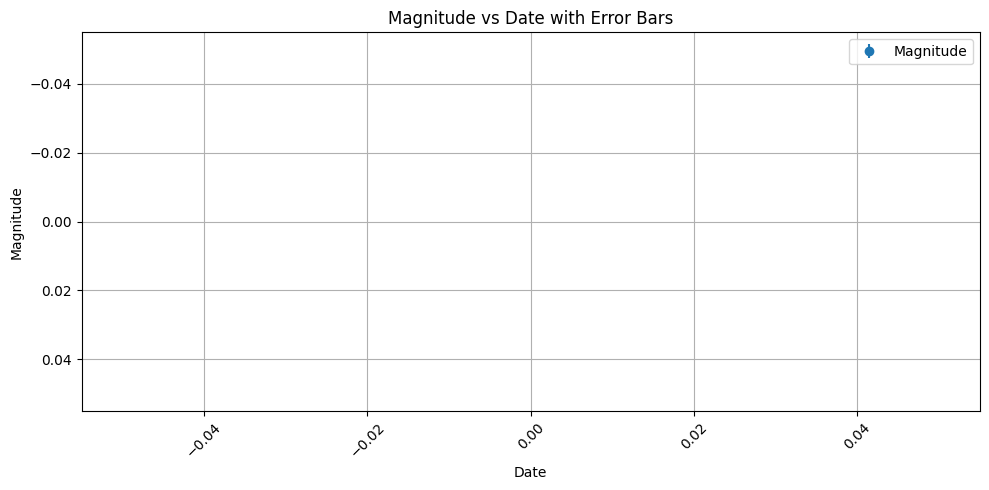

In [ ]:
import matplotlib.pyplot as plt
import datetime

# Extract dates, magnitudes, and errors
dates = [datetime.datetime.strptime(entry[0][:8], '%Y%m%d') for entry in data]
magnitudes = [entry[1] for entry in data]
errors = [entry[2] for entry in data]

# Create the plot
plt.figure(figsize=(10, 5))
plt.errorbar(dates, magnitudes, yerr=errors, fmt='o', capsize=5, label='Magnitude')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Magnitude')
plt.title('Magnitude vs Date with Error Bars')
plt.gca().invert_yaxis()  # Magnitude typically decreases upwards
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()
